# Preprocessing and Training Data Development

Two things I want to explore: 
* Is there a **particle count** difference between locations with **CFU** measurements above below 10?
* Are particulate counts an indicator of CFU counts?

In [1]:
#importing the tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft
import featuretools.variable_types as vtypes


from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split

In [2]:
file = 'data\combined_VAS.csv'
file2 = 'data\cfu.csv'
file3 = 'data\prtc.csv'

df = pd.read_csv(file,index_col=0,parse_dates=True)
cfu = pd.read_csv(file2,index_col=0,parse_dates=True)
prtc = pd.read_csv(file3,index_col=0,parse_dates=True)

df['Date'] = pd.to_datetime(df['Date'])
df['cfu'] = pd.to_numeric(df['cfu'])
df.reset_index()
df.dtypes,df.shape

(Date                      datetime64[ns]
 location                          object
 Temp                             float64
 RH                               float64
 Total_Particles>0.3              float64
 Total_Particles>0.5/m3           float64
 Traffic                           object
 Weather                           object
 cfu                              float64
 Source                            object
 dtype: object,
 (859, 10))

In [3]:
df['threshold'] = np.where(df['cfu'] < 10, 'under','over')
df = df[df['RH'] >10]
df['sample_id'] = df['Date'].astype(str) + '/' + df['location'].astype(str).str.lower().str.replace(' ','-')
df = df.set_index('sample_id')
dfo=df.select_dtypes(include=['object','category']) # select object type columns
df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

In [4]:
X = df.drop(columns='cfu')
y = df.cfu
scaler_pt = PowerTransformer()
scaler = StandardScaler()

X['prt3_lg'] = scaler_pt.fit_transform(X[['Total_Particles>0.3']])
X['prt5_lg'] = scaler_pt.fit_transform(X[['Total_Particles>0.5/m3']])
X['temp_ss'] = scaler.fit_transform(X[['Temp']])
X['rh_ss'] = scaler.fit_transform(X[['RH']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
X_train.shape, X_train.describe()

((643, 104),
              Temp          RH  Total_Particles>0.3  Total_Particles>0.5/m3  \
 count  643.000000  643.000000         6.430000e+02            6.430000e+02   
 mean    71.502240   45.765941         4.540640e+04            1.271475e+06   
 std      3.727169    9.666342         1.016771e+05            2.476520e+06   
 min     38.900000   15.000000         7.640900e+01            4.950000e+02   
 25%     70.300000   40.500000         3.068000e+03            1.616440e+05   
 50%     72.100000   47.000000         1.440300e+04            4.400990e+05   
 75%     73.700000   51.450000         4.711550e+04            1.135974e+06   
 max     82.100000   78.700000         1.338270e+06            2.794541e+07   
 
        location_11L NS  location_11L SEC  \
 count       643.000000        643.000000   
 mean          0.023328          0.031104   
 std           0.151061          0.173734   
 min           0.000000          0.000000   
 25%           0.000000          0.000000   
 50%

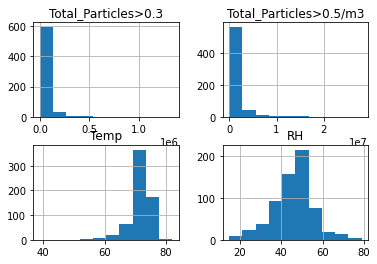

In [6]:
X_train[['Total_Particles>0.3','Total_Particles>0.5/m3','Temp','RH']].hist()
plt.show()

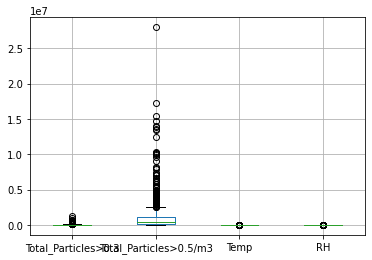

In [7]:
X_train[['Total_Particles>0.3','Total_Particles>0.5/m3','Temp','RH']].boxplot()
plt.show()

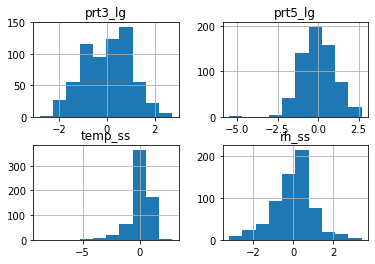

In [8]:
X_train[['prt3_lg','prt5_lg','temp_ss','rh_ss']].hist()
plt.show()

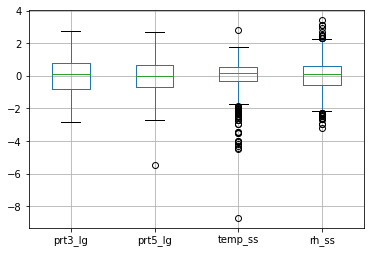

In [9]:
X_train[['prt3_lg','prt5_lg','temp_ss','rh_ss']].boxplot()
plt.show()

In [10]:
X_train

,Date,Temp,RH,Total_Particles>0.3,Total_Particles>0.5/m3,location_11L NS,location_11L SEC,location_350 Parnassus Suite 300 by reception area,location_350 Parnassus Suite 300 just outside containment,location_9L NS,...,Weather_Sunny,Source_MB,Source_ML,Source_adhoc,threshold_over,threshold_under,prt3_lg,prt5_lg,temp_ss,rh_ss
sample_id,,,,,,,,,,,,,,,,,,,,,
2017-01-20/9l-sec,2017-01-20,73.2,39.1,11643.0,501430.0,0,0,0,0,0,...,0,0,1,0,0,1,-0.035726,0.095219,0.440194,-0.689727
2017-12-22/ho-c6847a,2017-12-22,74.0,21.0,1084.0,97703.0,0,0,0,0,0,...,0,1,0,0,0,1,-1.370466,-1.085071,0.653930,-2.562468
2016-02-26/gt2-c5,2016-02-26,68.2,48.5,426.0,26200.0,0,0,0,0,0,...,0,1,0,0,0,1,-1.885626,-2.094078,-0.895652,0.282856
2016-03-21/11l-sec,2016-03-21,73.2,50.0,61377.0,1449823.0,0,1,0,0,0,...,0,0,1,0,0,1,0.919818,0.820119,0.440194,0.438056
2015-04-24/ho-c6s80,2015-04-24,76.6,38.8,77102.0,2588173.0,0,0,0,0,0,...,0,1,0,0,0,1,1.052284,1.202665,1.348570,-0.720767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-14/b1-a5,2018-09-14,73.0,49.0,4868.0,273145.0,0,0,0,0,0,...,0,1,0,0,0,1,-0.530094,-0.333945,0.386760,0.334589
2018-07-31/l53,2018-07-31,71.6,52.0,17565.0,194700.0,0,0,0,0,0,...,0,0,1,0,0,1,0.199036,-0.577802,0.012723,0.644988
2017-06-29/ho-c6801,2017-06-29,73.4,45.0,3345.0,253180.0,0,0,0,0,0,...,0,1,0,0,0,1,-0.741356,-0.388324,0.493628,-0.079276
